In [1]:
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
from matplotlib import rcParams
from scipy import io
import os


In [2]:
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 600
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'
rcParams['animation.embed_limit'] = 2**128
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title


### Parameter definition 

In [3]:
# parameters in the dimensionless model
a=4.0;   # Alpha in the model 
b=1.0;   # Beta in the model
T=7.0;   # Tau in the model
Da=1/16; # Delta in model
Db=1.0;

### Simulation settings

In [4]:
length    = 512.0      # 2.5 Length of the physical landscape
n         = 1024        # Size of the 2D grid
endtime   = 20000.0       #end time
dT        = 0.02         #0.02     #calculate time step
nplot     = 300
nsteps    = np.ceil(endtime/nplot/dT).astype(int)    #number of time steps

### Precalculations

In [5]:
dX = length/n      # Spatial step size
dY = length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 1024 x 1024 cells



### Defining the device that is used

In [6]:
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon Pro 5700 XT Compute Engine



In [7]:
np.mean(np.mean(np.random.rand(n*n)))

0.5000164800668532

### Initial values

In [8]:
# The array is allocated on the GPU and the initial values are copied onto it
A0       = (T-b+np.sqrt((T-b)**2-(a-T*b)))/2
A        = A0 + (np.random.rand(n*n)-0.5)*0.1
#(np.sqrt(a)-b + np.sqrt(a/c)-b)/2 + (np.random.rand(n*n)-0.5)
A_host   = A.astype(np.float32)
A_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=A_host)

B0       = T-A0
B        = B0 + (np.random.rand(n*n)-0.5)*0.1
B_host   = B.astype(np.float32)
B_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=B_host)

In [9]:
# np.sum(A)/n/n

In [10]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

### Defining the OpenCL simulation kernel

In [11]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel

PassVars="Da,a,b,Db,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

In [12]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* A, __global float* B)
{
    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {
             float dAdt =   A[current]*B[current] - a*A[current]/(A[current]+b) + Da*d2_dxy2(A);
             float dBdt =   a*A[current]/(A[current]+b) - A[current]*B[current] + Db*d2_dxy2(B);
             
             A[current] = A[current] + dAdt*dT;
             B[current] = B[current] + dBdt*dT;
            }
            
        // HANDLE Boundaries
        else 
            {
             NeumannBoundaries(A);
             NeumannBoundaries(B);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [13]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

In [14]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

As=np.zeros((Grid_Width, Grid_Height, nplot))
Bs=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = A_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    for jj in range(1,nsteps):      
        program.SimulationKernel(queue, global_size, None, A_g, B_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, A_host, A_g)
    cl.enqueue_copy(queue, B_host, B_g)
    
    # We store the state of the system for <NumPlot> different times.
    As[:,:,ii] = A_host.reshape(Grid_Width, Grid_Height)
    Bs[:,:,ii] = B_host.reshape(Grid_Width, Grid_Height)
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))


Progress :


FloatProgress(value=0.0, max=300.0)

 Simulation took      : 294.8 (s)


In [15]:
from scipy import io
import os
if not os.path.exists("data"):
    os.makedirs("data")
io.savemat('data/UV_data.mat', {'A': As, 'B': Bs})
# load data: mathfn.mat from Matlab
# data = io.loadmat(matfn) 

# Plotting the results

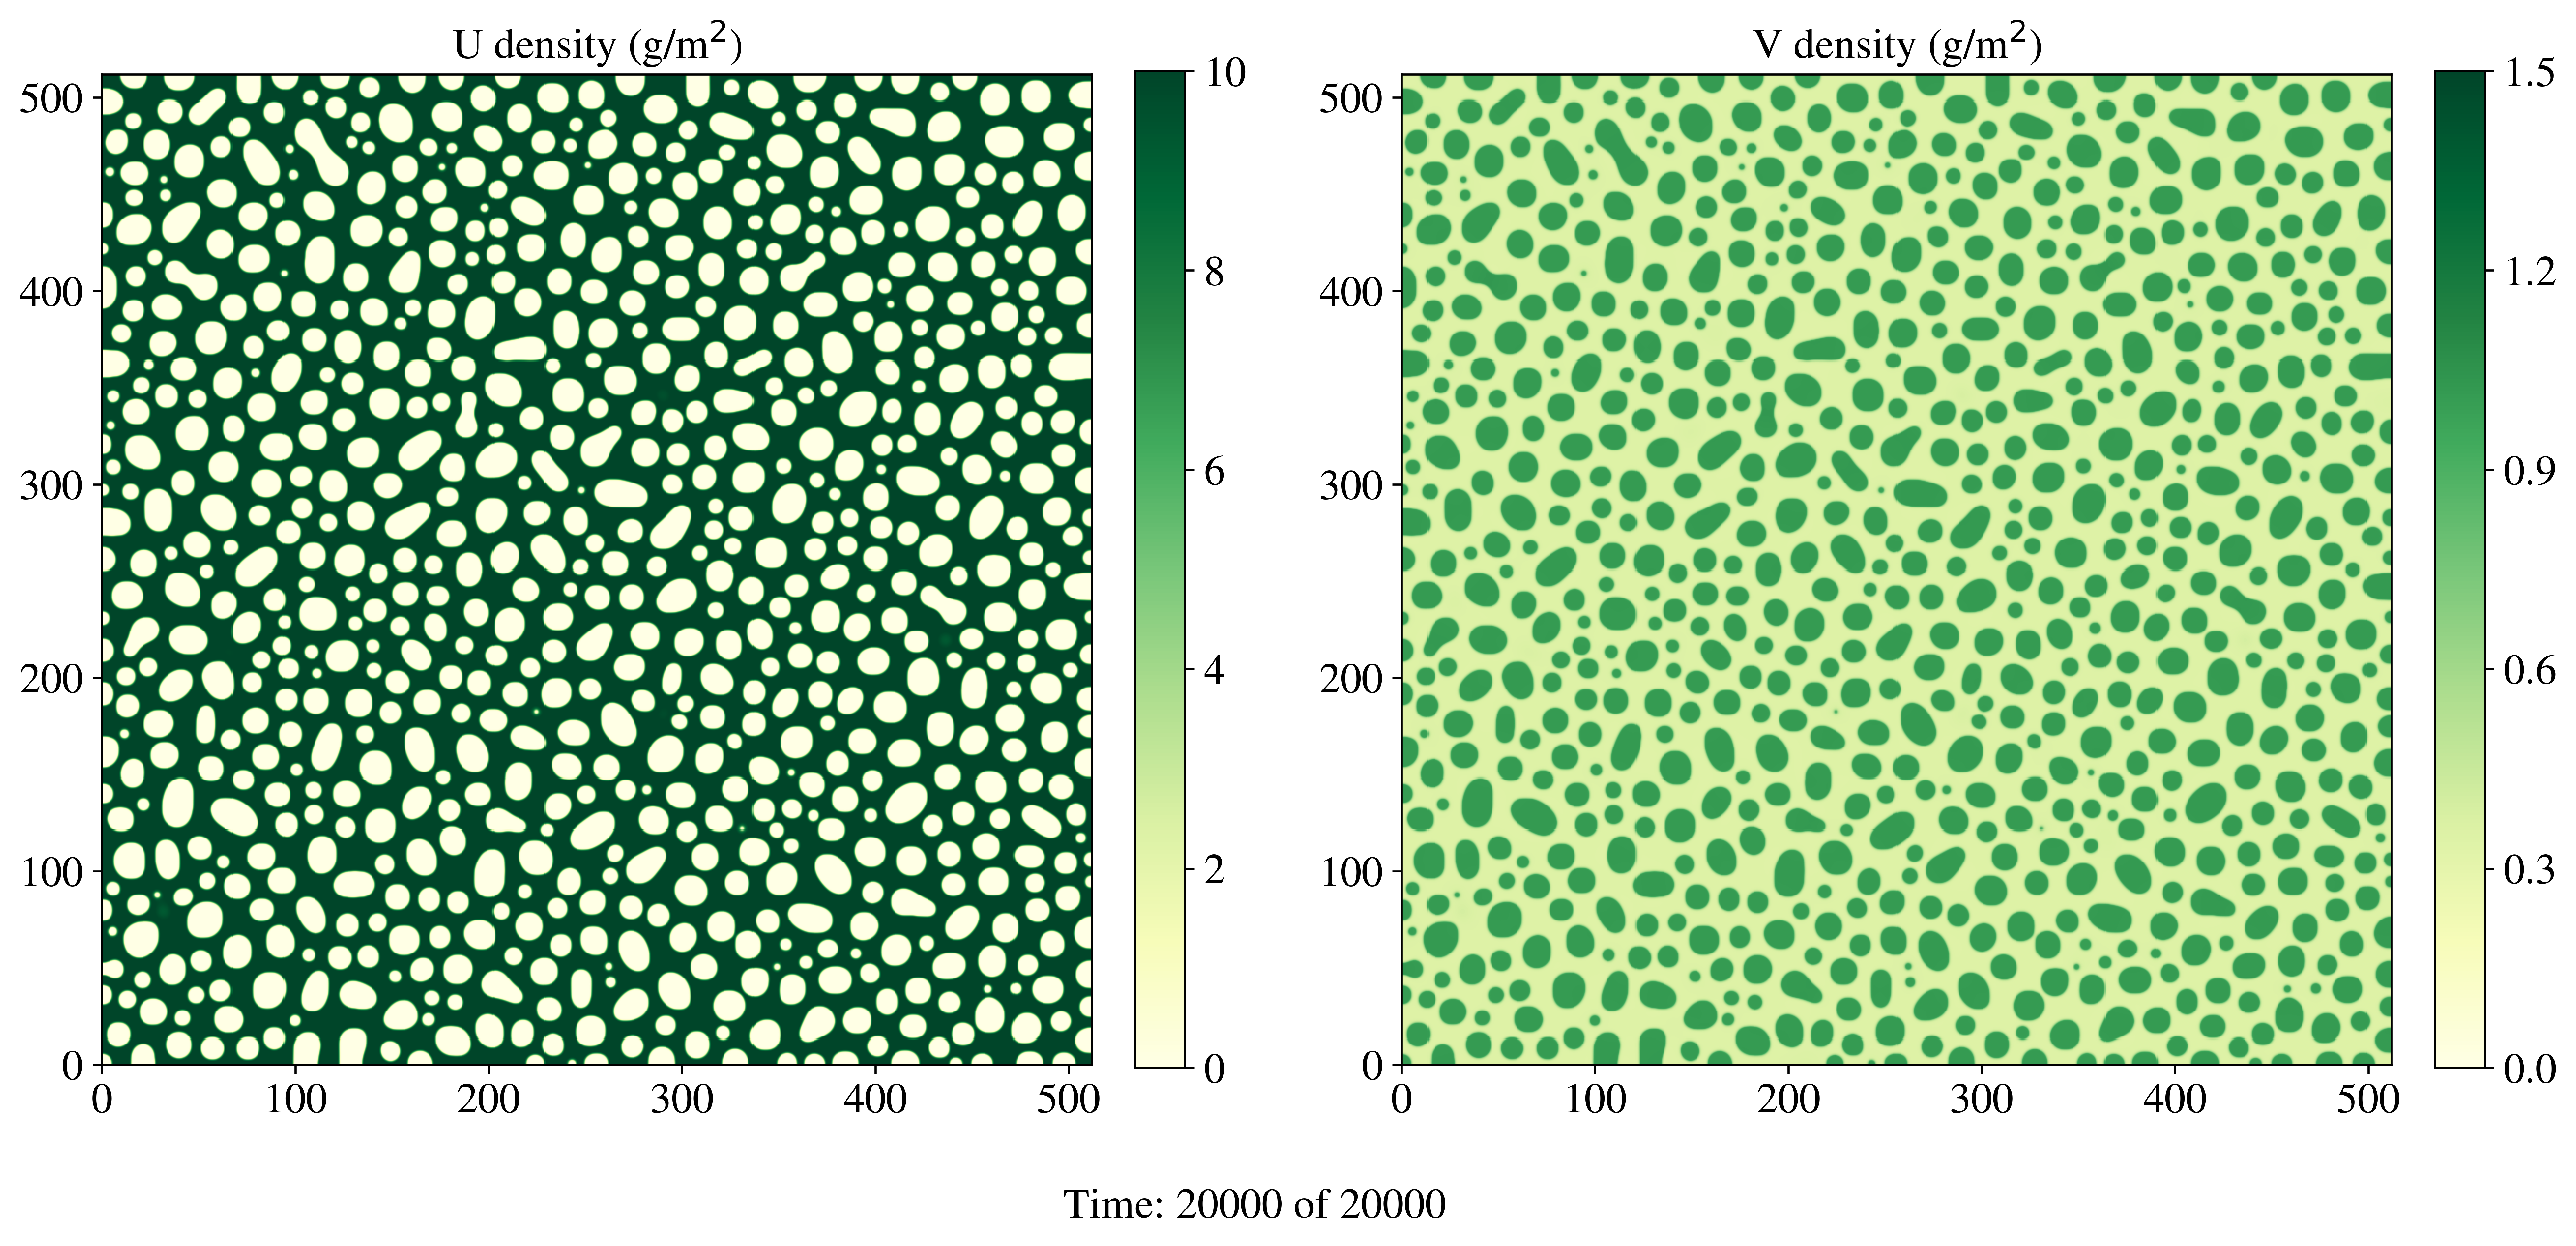

In [16]:
### The Simulation loop
from matplotlib import ticker
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
im0 = ax[0].imshow(A_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length],clim=(0,10));#, clim=(0,0.1));
ax[0].set_title('U density (g/m$^2$)');
cbar=plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,5))
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

im1 = ax[1].imshow(B_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length],clim=(0,1.5));#, clim=(0,0.5));
ax[1].set_title('V density (g/m$^2$)');
cbar=plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);
# ax[1].set_yticks(np.linspace(0,length,5))
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.1, fontsize=16);

# Making a movie

In [17]:
from matplotlib import animation, rc
if not os.path.exists("Images"):
    os.makedirs("Images")
    
def updatefig(i): # To update the image at each iteration
    global As, Bs
    im0.set_array(As[:,:,i])
    im1.set_array(Bs[:,:,i])
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endtime, endtime));
    fig.savefig('Images/Images%03d' % (i)+'.pdf',bbox_inches='tight',dpi=600)
    return im0,im1,

ani = animation.FuncAnimation(fig, updatefig, interval=200, frames = nplot, repeat=False, blit=True)
print("Save figure finshes!")

Save figure finshes!


In [18]:
from IPython.display import HTML
# HTML(ani.to_html5_video()) 
 
# write to an mp4 movie or 'avconv' or 'imagemagick' or 'ffmpeg'
Writer = animation.writers['ffmpeg'] 
writer = Writer(fps=10, bitrate=1800)
ani.save('Movie_S1.mp4', writer=writer,dpi=600)
print("Save movies finshes!")

Save movies finshes!


## The End, Kang. 2020.0707